# prep

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grat_SF6_allen_nat8')]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1380,230330,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
1,1380,230330,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
2,1380,230330,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
3,1381,230404,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
4,1381,230404,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
5,1381,230404,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
6,1386,230406,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,unsure if this is V1 due to sparse cells and i...
7,1386,230406,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
8,1386,230406,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
9,1374,230411,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN


# batch write df_tidy, multisess
already done. no need to rerun

In [30]:
for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    print(mouse, date, area, 'multisess')
    dir_identifier = f'{area}_{imouse}_{date}'
    print(dir_identifier)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab
    assert len(np.unique(stim_id)) == 14 # for mix14
    
    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg
    
    stim_id = stim_id[0] # unwrap list of list
    stim_id = stim_id[:ntrial] # if stim info longer than ntrial, slice off the last one
    stim_id_col = np.tile(stim_id, ncell) # make stim info col: same as trial_id - tile then hsatck
    stim_id_col = np.hstack((stim_id_col, stim_id_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 
                            'resp_id': resp_id, 'stim_id': stim_id_col,})
    df_tidy['area'] = area

    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()
    # break
    
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy.csv'), index=False)

clear_output()

# batch load df_tidy

In [4]:
df_tidy = pd.DataFrame()

for idate in tqdm(meta.date.unique()):

    mouse = meta.loc[meta.date == idate, 'mouse'].head(1).values[0].astype(str) # take meta info from first session. very roundabout way to do this, bc index changes after slicing
    imouse = 'i' + mouse
    date = idate.astype(str)
    area = meta.loc[meta.date == idate, 'area'].head(1).values[0]

    print(imouse, date, area, 'multisess')
    dir_identifier = f'{area}_{imouse}_{date}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                            + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [5]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.area.unique(), )
print(sorted(df_tidy.stim_id.unique()), # NOTE: 0-based indexing. grating x6 (img 0-5), then natural image x8 (img 6-13). see stim image files here: Z:\All_Staff\home\lan\Mwork\grat_SF6_allen_nat8\Image
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1380' '1381' '1386' '1374' '1387' '1375'] ['230330' '230404' '230406' '230411' '230418' '230425'] ['V1']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,stim_id,area,filter_cell_vis,filter_cell_stim,mouse,date
1001396,0.055331,230406_22,554,R1,3,V1,True,False,1386,230406
1860208,-0.060029,230418_5,1282,R2,5,V1,True,False,1387,230418
633495,0.108687,230404_80,675,R1,12,V1,True,False,1381,230404
2003814,0.040365,230418_96,198,R2,12,V1,True,False,1387,230418
594580,-0.020834,230404_55,1510,R1,8,V1,True,True,1381,230404


# filter cell

## filter cell by cutoff R1
exlude cells if even their max-resp across stims is too small  
cutoff is set as lower 5 percentile

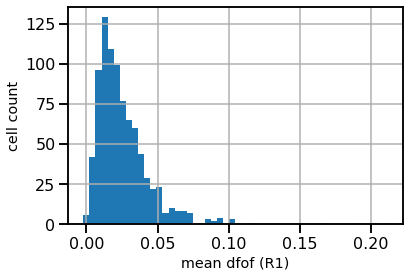

In [9]:
df_tidy[df_tidy.resp_id == 'R1'].groupby('cell_id').dfof.mean().hist(bins=50);
plt.xlabel('mean dfof (R1)');
plt.ylabel('cell count');

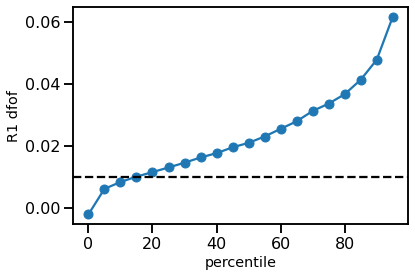

In [10]:
R1_dist = df_tidy[df_tidy.resp_id == 'R1'].groupby('cell_id').dfof.mean().values

percentile_arr = np.arange(0, 100, 5)
R1_perc = np.percentile(R1_dist, percentile_arr)

plt.plot(percentile_arr, R1_perc, 'o-');
plt.axhline(0.01, color='k', linestyle='--');
plt.xlabel('percentile');
plt.ylabel('R1 dfof');

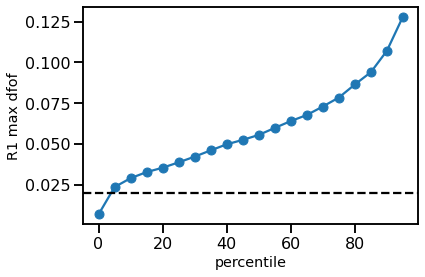

In [11]:
R1_cell_stim = df_tidy[df_tidy.resp_id == 'R1'].groupby(['cell_id', 'stim_id']).dfof.mean().to_frame().reset_index()
R1_cutoff = 0.02

# R1_cell_stim.groupby('cell_id').dfof.max().hist(bins=50); # should exclude cell if even max R1 across stims is small
# plt.axvline(R1_cutoff, color='k', linestyle='--');
# (R1_cell_stim_max < R1_cutoff).sum(), len(R1_cell_stim_max)

R1_cell_stim_max = R1_cell_stim.groupby('cell_id').dfof.max().values
R1_max_perc = np.percentile(R1_cell_stim_max, percentile_arr)
plt.plot(percentile_arr, R1_max_perc, 'o-');
plt.axhline(R1_cutoff, color='k', linestyle='--');
plt.xlabel('percentile');
plt.ylabel('R1 max dfof');

In [12]:
R1_cutoff = np.percentile(R1_max_perc, 5) # exclude cells with max R1 dfof across stims < 5th percentile

cell_list = R1_cell_stim.groupby('cell_id').dfof.max().reset_index()['cell_id'].values
filter_cell_R1 = R1_cell_stim.groupby('cell_id').dfof.max().values >= R1_cutoff
cell_R1_pass = cell_list[filter_cell_R1] # cells who passed R1 cutoff filter
len(cell_R1_pass), len(cell_list)

(821, 860)

In [13]:
df_tidy['filter_cell_R1'] = False
df_tidy['filter_cell_R1'] = df_tidy['cell_id'].apply(lambda x: True if x in cell_R1_pass else False)
assert sorted(cell_list[~filter_cell_R1]) == sorted(df_tidy[df_tidy.filter_cell_R1 == False].cell_id.unique())
df_tidy

,dfof,cell_id,trial_id,resp_id,stim_id,area,filter_cell_vis,filter_cell_stim,mouse,date,filter_cell_R1
0,-0.022064,230330_0,0,R1,1,V1,True,True,1380,230330,True
1,0.077962,230330_0,1,R1,12,V1,True,False,1380,230330,True
2,-0.023058,230330_0,2,R1,13,V1,True,True,1380,230330,True
3,0.124579,230330_0,3,R1,8,V1,True,False,1380,230330,True
4,-0.029692,230330_0,4,R1,0,V1,True,False,1380,230330,True
...,...,...,...,...,...,...,...,...,...,...,...
2731831,-0.074684,230425_194,1585,R2,12,V1,True,False,1375,230425,True
2731832,0.041901,230425_194,1586,R2,3,V1,True,True,1375,230425,True
2731833,0.007992,230425_194,1587,R2,10,V1,True,False,1375,230425,True
2731834,0.053189,230425_194,1588,R2,6,V1,True,False,1375,230425,True


# fast reload df_tidy

In [14]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_mix14.csv'), index=False)

# ## reload df_tidy
# df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_mix14.csv'))

## filter cell-stim by pref grat SF
to prepare for adp-SF plot

In [15]:
df_pref = df_tidy[df_tidy['filter_cell_vis'] # vis driven filter
                # & df_tidy['filter_cell_stim'] # img driven filter
                & df_tidy['filter_cell_R1'] # R1 cutoff filter
                & (df_tidy['stim_id'] < 6) # gratings only, stim id 0-5. NOTE: must have parentheses () around it!
                ]
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in tqdm(df_pref.cell_id.unique()):
    df_cell = df_pref[(df_pref['cell_id']==icell) & (df_pref['resp_id']=='R1')] # only use R1 to calc pref SF
    if len(df_cell) == 0:
        continue
    df_cell = (df_cell.groupby(['stim_id'])['dfof'].mean().reset_index() # mean dfof of each stim
                      .sort_values(by='dfof', ascending=False))  # sort by dfof, largest first
                      
    pref_stim = df_cell.iloc[0]['stim_id'].astype(int) # stim id of the largest resp
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True
df_pref

df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo

C:\Users\ll357\AppData\Local\Temp\6\ipykernel_46396\464894796.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pref['filter_pref'] = False
100%|██████████| 818/818 [02:15<00:00,  6.03it/s]


In [19]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_pref.to_csv(os.path.join(dir_data, 'df_tidy_grat6_pref_in_mix14.csv'), index=False)

# # ## reload df_tidy
# # df_pref = pd.read_csv(os.path.join(dir_data, 'df_tidy_grat6_pref_in_mix14.csv'))

# adaptation vs preferred SF

In [20]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 1000
nrep_selected = 30 # dictated by grat1 adp stability test
seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap

adp_boot = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot]) # select same trial reps for R1 and R2
                    .mean())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot])
                    .mean())
                    .reset_index()['dfof'].values)
    
    # adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7) # IOU version
    adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7) # diff over R1 version
    
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    # adp_agg[np.abs(R2_agg + R1_agg) < 0.1] = np.nan
    # adp_agg[np.abs(R1_agg) < 0.01] = np.nan
    
    adp_boot.append(adp_agg)

print('adp hard thresholding')

adp_boot = np.array(adp_boot)

100%|██████████| 1000/1000 [10:12<00:00,  1.63it/s]

adp hard thresholding


In [23]:
# adp_boot shape = nboot x (nstim x ncell, preferred), but essentially nboot x ncell, bc each cell only has 1 preferred stim

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1') & (df_pref['stim_id'] < 6)] # TODO: fix code above to do this already
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum()) # dfof col was not used
                .reset_index())

# agg_method = np.nanmedian
agg_method = np.nanmean

adp_boot_agg = agg_method(adp_boot, axis=0) # agg over all bootstraps
df_adp_pref['adp_pref'] = adp_boot_agg

df_adp_pref = df_adp_pref.dropna(subset=['adp_pref']) # remove nan, which is adp outliers
df_adp_pref.tail(), df_adp_pref.shape, df_adp_pref.stim_id.max()

(     stim_id     cell_id      dfof  adp_pref
 813        5  230425_147  1.594514  0.096761
 814        5   230425_28  0.010284  0.307226
 815        5   230425_47  2.689243 -0.042482
 816        5   230425_58  0.175154 -0.438129
 817        5    230425_9  0.887202  0.649820,
 (818, 4),
 5)

## fast reload df_adp_pref

In [21]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
df_pref.to_csv(os.path.join(dir_data, 'df_tidy_grat6_adp_pref_in_mix14.csv'), index=False)

# ## reload df_tidy
# df_pref = pd.read_csv(os.path.join(dir_data, 'df_tidy_grat6_adp_pref_in_mix14.csv'))

## boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

In [197]:
# df_adp_pref.loc[df_adp_pref['stim_id'] == 0, 'stim_id'] = 1 # merge stim 0 and 1
# df_adp_pref

,stim_id,cell_id,dfof,adp_pref
0,1,230330_136,0.986366,-1.655030
1,1,230330_140,0.874818,-0.741070
2,1,230330_153,1.256782,-0.645777
3,1,230330_2,0.904460,-0.395211
4,1,230330_58,0.919261,0.071772
...,...,...,...,...
813,5,230425_147,0.850959,0.159320
814,5,230425_28,0.401071,0.363329
815,5,230425_47,0.303938,0.006234
816,5,230425_58,0.038706,-0.442366


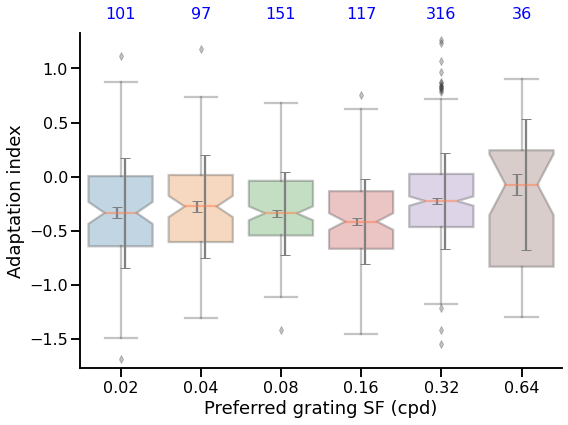

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, 
            notch=True, 
            boxprops=dict(alpha=.3), 
            whiskerprops=dict(alpha=.3),
            capprops=dict(alpha=.3),
            flierprops=dict(alpha=.3),
            medianprops={"color": "coral", "alpha": .5},
            meanprops={"color": "orange"},)
# sns.swarmplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, alpha=0.5) # set figsize to (18, 6) for swarmplot

adp_pref_agg = df_adp_pref.groupby('stim_id')['adp_pref'].median().values # or use mean()
adp_pref_std = df_adp_pref.groupby('stim_id')['adp_pref'].std().values
adp_pref_sem = df_adp_pref.groupby('stim_id')['adp_pref'].sem().values
ax.errorbar(np.arange(adp_pref_agg.shape[0])+0.05, adp_pref_agg,
            yerr=adp_pref_std, fmt='none', color='gray', capsize=5)
ax.errorbar(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)

ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 1.5, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')

SF_ref = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd. this should be updated to match # batch rewrite df tidy
# SF_ref = SF_ref[1:] # if merged stim 0 and 1
cpd_array = np.round(SF_ref, 2)
ax.set_xticklabels(cpd_array)
ax.set_xlabel('Preferred grating SF (cpd)', fontsize=18)
ax.set_ylabel('Adaptation index', fontsize=18)
ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), np.nanmax(df_adp_pref['adp_pref'].values * 1.05)])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
# dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
# fig.savefig(os.path.join(dir_fig, 'adp_pref_grat_SF6_diff_over_R1.pdf'), bbox_inches='tight')

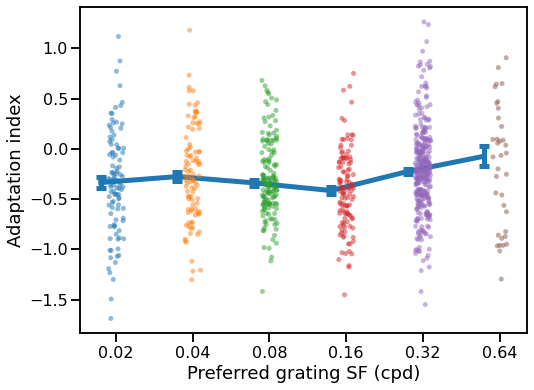

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, alpha=0.5); # set figsize to (18, 6) for swarmplot
ax.errorbar(np.arange(adp_pref_agg.shape[0])-0.2, 
            adp_pref_agg,
            yerr=adp_pref_sem, 
            linewidth=5, capsize=5, capthick=5);
ax.set_xticklabels(cpd_array);
ax.set_xticklabels(cpd_array)
ax.set_xlabel('Preferred grating SF (cpd)', fontsize=18)
ax.set_ylabel('Adaptation index', fontsize=18);

## stats

### one way anova

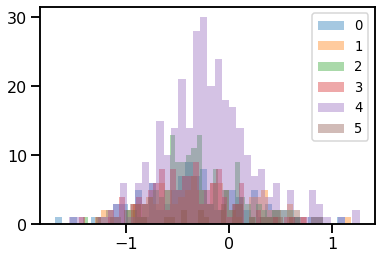

In [27]:
# test assumption of normality: looks maybe normal, need Shapiro-Wilk test

df_adp_pref_dropna = df_adp_pref.dropna(subset=['adp_pref'])
gb = df_adp_pref_dropna.groupby('stim_id')
adp_SF = []
for stim_id, group in gb:
    # print(stim_id)
    # print(group)
    # print(group['adp_pref'].values[:5])
    adp_iSF = group['adp_pref'].values
    adp_SF.append(adp_iSF)
    plt.hist(adp_iSF, bins=40, alpha=0.4, label=stim_id)
plt.legend();

In [28]:
# test assumption of equal variance: looks not equal, need Levene test, bartlett test, or fligner-killeen test
# "ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power" - https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance
adp_SF_var = [np.var(adp_iSF) for adp_iSF in adp_SF]
adp_SF_var

# test assumption of independence: no idea

[0.2565924764785657,
 0.22165874201110278,
 0.14660475652107274,
 0.1554904006296723,
 0.19633739452017002,
 0.3578646813361963]

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_adp_pref_dropna = df_adp_pref.dropna()

# perform one-way ANOVA
import scipy.stats as stats
stats.f_oneway(
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==0]['adp_pref'].values, # if merged stim 0 and 1
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==1]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==2]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==3]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==4]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==5]['adp_pref'].values,
                )

F_onewayResult(statistic=4.157539362649587, pvalue=0.000979028581628212)

### non parametric test: kruskal-wallis
dont have to satisfy anova assumptions

In [31]:
stats.kruskal(
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==0]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==1]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==2]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==3]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==4]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==5]['adp_pref'].values,
            )

KruskalResult(statistic=20.920875349254857, pvalue=0.0008384205395621565)

# linear decoder

## subpop divide

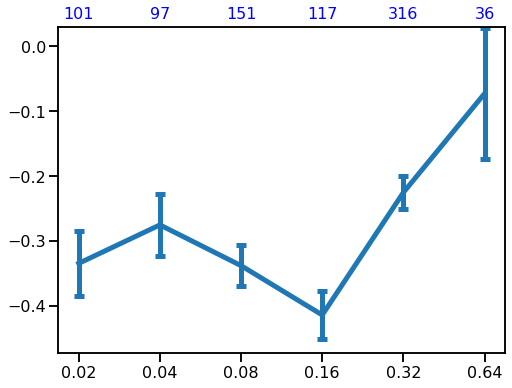

In [39]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(np.arange(adp_pref_agg.shape[0]), 
            adp_pref_agg,
            yerr=adp_pref_sem, 
            linewidth=5, capsize=5, capthick=5);

ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 0.05, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')

ax.set_xticks(np.arange(adp_pref_agg.shape[0]));
ax.set_xticklabels(cpd_array);
ax.set_ylim([np.nanmin(adp_pref_agg - adp_pref_sem) * 1.05, np.nanmax(adp_pref_agg + adp_pref_sem) * 1.05]);

Ttest_indResult(statistic=-3.641886440344554, pvalue=0.00028772636654339896)

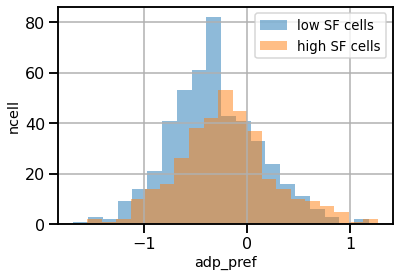

In [43]:
## expectation: "stable cells" should be cells preferring stim 4-5, aka the highest SFs
## "adapting cells" should be cells preferring stim 0-3, aka low-mid SFs
## to ensure equal ncell, take all stable cells. for adapting cells, take all cells preferring stim 3, subsample cells preferring stim 1-2
## lets test this grouping

low_SF_adp = df_adp_pref[df_adp_pref.stim_id.isin([0, 1, 2, 3])].adp_pref
high_SF_adp = df_adp_pref[df_adp_pref.stim_id.isin([4, 5])].adp_pref

low_SF_adp.hist(bins=20, alpha=0.5);
high_SF_adp.hist(bins=20, alpha=0.5);
plt.xlabel('adp_pref');
plt.ylabel('ncell');
plt.legend(['low SF cells', 'high SF cells']);

stats.ttest_ind(low_SF_adp, high_SF_adp) # significant difference, try linear decoder on these two groups

In [44]:
low_SF_cell = df_adp_pref[df_adp_pref.stim_id.isin([0, 1])].cell_id.values # subsample from here, add to mid_SF_cell
mid_SF_cell = df_adp_pref[df_adp_pref.stim_id.isin([2, 3])].cell_id.values # this should match stable subpop
high_SF_cell = df_adp_pref[df_adp_pref.stim_id.isin([4, 5])].cell_id.values # this should match adapting subpop

np.random.seed(123) # randomly subsample from low_SF_cell
subsample_ncell = len(high_SF_cell) - len(mid_SF_cell)
low_SF_cell_subsample = np.random.choice(low_SF_cell, size=subsample_ncell, replace=False)

mid_SF_cell = np.concatenate((mid_SF_cell, low_SF_cell_subsample))
assert len(mid_SF_cell) == len(high_SF_cell)